# Approach 4: Autoencoder - Boxplot
This notebook reads eval results of sets of identical trainings and plots them into a boxplot. The names of the training results can be configured in the cell below.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.neighbors import KernelDensity
from glob import glob
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm

from py.Dataset import Dataset
from py.FileUtils import load
from py.PlotUtils import get_percentiles

DIR = '/home/kleinsteuber/vscode/ResizedSessions256_NoBackup' # dataset directory
CONFIGS_BY_LATENT_FEATURES = [
    {
        "label": "16",
        "train_names": [f"ae2_beaver_01_16f_200e_{i}" for i in range(10)]
    },
    {
        "label": "32",
        "train_names": [f"ae2_beaver_01_32f_200e_{i}" for i in range(10)]
    },
    {
        "label": "64",
        "train_names": [f"ae2_beaver_01_64f_200e_{i}" for i in range(10)]
    },
    {
        "label": "128",
        "train_names": [f"ae2_beaver_01_128f_200e_{i}" for i in range(10)]
    },
    {
        "label": "256",
        "train_names": [f"ae2_beaver_01_256f_200e_{i}" for i in range(10)]
    },
    {
        "label": "512",
        "train_names": [f"ae2_beaver_01_200e_{i}" for i in range(10)]
    },
    {
        "label": "1024",
        "train_names": [f"ae2_beaver_01_200e_{i}" for i in range(10)]
    },
]

CONFIGS_DENOISING = [
    {
        "label": "0",
        "train_names": [f"ae2_beaver_01_200e_{i}" for i in range(10)]
    },
    {
        "label": "0.100",
        "train_names": [f"ae2_beaver_01_noise0.01_200e_{i}" for i in range(10)]
    },
    {
        "label": "0.150",
        "train_names": [f"ae2_beaver_01_noise0.0225_200e_{i}" for i in range(10)]
    },
    {
        "label": "0.200",
        "train_names": [f"ae2_beaver_01_noise0.04_200e_{i}" for i in range(10)]
    },
    {
        "label": "0.300",
        "train_names": [f"ae2_beaver_01_noise0.09_200e_{i}" for i in range(10)]
    },
    {
        "label": "0.400",
        "train_names": [f"ae2_beaver_01_noise0.16_200e_{i}" for i in range(10)]
    },
]

CONFIGS_SPARSE = [
    {
        "label": "0",
        "train_names": [f"ae2_beaver_01_200e_{i}" for i in range(10)]
    },
    {
        "label": "1e-5",
        "train_names": [f"ae2_beaver_01_sparse1e-5_200e_{i}" for i in range(10)]
    },
    {
        "label": "1e-4",
        "train_names": [f"ae2_beaver_01_200e_sparse_{i}" for i in range(10)]
    },
    {
        "label": "1e-3",
        "train_names": [f"ae2_beaver_01_sparse1e-3_200e_{i}" for i in range(10)]
    },
    {
        "label": "1e-2",
        "train_names": [f"ae2_beaver_01_sparse1e-2_200e_{i}" for i in range(10)]
    },
]

CONFIGS_DENOISING_AND_SPARSE = [
    {
        "label": "Base",
        "train_names": [f"ae2_beaver_01_200e_{i}" for i in range(10)]
    },
    {
        "label": "σ = 0.1",
        "train_names": [f"ae2_beaver_01_noise0.01_200e_{i}" for i in range(10)]
    },
    {
        "label": "σ = 0.15",
        "train_names": [f"ae2_beaver_01_noise0.0225_200e_{i}" for i in range(10)]
    },
    {
        "label": "σ = 0.2",
        "train_names": [f"ae2_beaver_01_noise0.04_200e_{i}" for i in range(10)]
    },
    {
        "label": "σ = 0.3",
        "train_names": [f"ae2_beaver_01_noise0.09_200e_{i}" for i in range(10)]
    },
    {
        "label": "σ = 0.4",
        "train_names": [f"ae2_beaver_01_noise0.16_200e_{i}" for i in range(10)]
    },
    {
        "label": "λ = 1e-5",
        "train_names": [f"ae2_beaver_01_sparse1e-5_200e_{i}" for i in range(10)]
    },
    {
        "label": "λ = 1e-4",
        "train_names": [f"ae2_beaver_01_200e_sparse_{i}" for i in range(10)]
    },
    {
        "label": "λ = 1e-3",
        "train_names": [f"ae2_beaver_01_sparse1e-3_200e_{i}" for i in range(10)]
    },
    {
        "label": "λ = 1e-2",
        "train_names": [f"ae2_beaver_01_sparse1e-2_200e_{i}" for i in range(10)]
    },
    #{
    #    "label": "σ = 0.1, λ = 1e-4",
    #    "train_names": [f"ae2_beaver_01_noise0.01_sparse1e-4_200e_{i}" for i in range(10)]
    #},
]

CONFIGS_COMPARE_SESSIONS = [
    {
        "session": "Beaver_01",
        "label": "Beaver_01",
        "train_names": [f"ae2_beaver_01_noise0.01_200e_{i}" for i in range(10)]
    },
    {
        "session": "Marten_01",
        "label": "Marten_01",
        "train_names": [f"ae2_marten_01_noise0.01_200e_{i}" for i in range(10)]
    },
    {
        "session": "GFox_03",
        "label": "GFox_03",
        "train_names": [f"ae2_gfox_03_noise0.01_200e_{i}" for i in range(10)]
    },
]

ds = Dataset(DIR)

Found 3 sessions


### Calculating the scores

In [5]:
def get_scores(train_names, session = "Beaver_01", **kwargs):
    kde_scores = {
        "auc": [],
        "tnr90": [],
        "tnr95": [],
        "tnr99": []
    }
    loss_scores = {
        "auc": [],
        "tnr90": [],
        "tnr95": [],
        "tnr99": []
    }
    # correct name
    session = ds.create_session(session).name
    for train_name in tqdm(train_names):
        try:
            lapse_losses, lapse_encodings, lapse_labels, lapse_images = load(f"./ae_train_NoBackup/{train_name}/eval/{session}_lapse.pickle")
            motion_losses, motion_encodings, motion_labels, motion_images = load(f"./ae_train_NoBackup/{train_name}/eval/{session}_motion.pickle")
        except:
            print(f"{train_name} is missing, skipping...")
            continue

        # # # # # # # # # # # # # # # # # #
        # 1. KDE AUC & elimination rates
        # # # # # # # # # # # # # # # # # #

        kde = KernelDensity(kernel="gaussian", bandwidth=0.01).fit(lapse_encodings)
        preds = kde.score_samples(motion_encodings)
        y_anom = preds[motion_labels == 1]
        y_norm = preds[motion_labels == 0]
        # likelihoods need to be inverted (anomalies have lower likelihood)
        X = -np.concatenate([y_norm, y_anom]).reshape((-1, 1))
        y = np.concatenate([-np.ones_like(y_norm), np.ones_like(y_anom)])

        fpr, tpr, thresholds = roc_curve(y, X[:,0])
        kde_scores["auc"].append(auc(fpr, tpr))
        kde_scores["tnr90"].append(get_percentiles(fpr, tpr, thresholds, percentiles=[0.9], verbose = False)[0])
        kde_scores["tnr95"].append(get_percentiles(fpr, tpr, thresholds, percentiles=[0.95], verbose = False)[0])
        kde_scores["tnr99"].append(get_percentiles(fpr, tpr, thresholds, percentiles=[0.99], verbose = False)[0])

        # # # # # # # # # # # # # # # # # # # # # # # # #
        # 2. Reconstruction Loss AUC & elimination rates
        # # # # # # # # # # # # # # # # # # # # # # # # #

        y_anom = motion_losses[motion_labels == 1]
        y_norm = motion_losses[motion_labels == 0]
        # likelihoods do not need to be inverted (anomalies have higher reconstruction loss)
        X = np.concatenate([y_norm, y_anom]).reshape((-1, 1))
        y = np.concatenate([-np.ones_like(y_norm), np.ones_like(y_anom)])

        fpr, tpr, thresholds = roc_curve(y, X[:,0])
        loss_scores["auc"].append(auc(fpr, tpr))
        loss_scores["tnr90"].append(get_percentiles(fpr, tpr, thresholds, percentiles=[0.9], verbose = False)[0])
        loss_scores["tnr95"].append(get_percentiles(fpr, tpr, thresholds, percentiles=[0.95], verbose = False)[0])
        loss_scores["tnr99"].append(get_percentiles(fpr, tpr, thresholds, percentiles=[0.99], verbose = False)[0])
    return kde_scores, loss_scores

### Plotting

In [3]:
def plot_boxes(values, color="darkgoldenrod", label_below=[], colors=None):
    bp_dict = plt.boxplot(values, medianprops={"linewidth": 1.5, "color": color}, widths=0.68)

    # Add labels to medians
    for i, line in enumerate(bp_dict['medians']):
        # get position data for median line
        x, y = line.get_xydata()[1] # top of median line
        # custom color
        if colors is not None:
            color = colors[i]
        line.set_color(color)
        # overlay median value
        if i in label_below:
            plt.text(x - 0.34, y - 0.0006, f"{y:.4f}"[1:], verticalalignment="top", horizontalalignment="center", color=color) # draw below, centered
        else:
            plt.text(x - 0.34, y + 0.0005, f"{y:.4f}"[1:], verticalalignment="bottom", horizontalalignment="center", color=color) # draw above, centered

def plot_scores(configs, scores, metric="auc", savefile=None, figsize=(15, 10), label_below=[], xlabel=None, colors=None):
    plt.figure(figsize=figsize)

    plot_boxes([kde_scores[metric] for kde_scores, loss_scores in scores], label_below=label_below, colors=colors)
    # plot_boxes([loss_scores[metric] for kde_scores, loss_scores in scores], color="blue")

    # Add labels
    plt.xticks(np.arange(1, len(configs) + 1), [config["label"] for config in configs])
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.grid(True, ls="dotted", lw=0.5)
    # plt.ylim((0.7, 0.9))
    # plt.legend()
    if savefile is not None:
        plt.savefig(savefile, bbox_inches="tight")
    plt.show()

# Plot result
## By latent features
Choose a metric ("auc", "tnr90", "tnr95", "tnr99") and optionally an output file for plotting.

In [6]:
scores = [get_scores(**config) for config in CONFIGS_BY_LATENT_FEATURES]

Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:00<00:00, 21.04it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:00<00:00, 15.49it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:00<00:00, 14.54it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:01<00:00,  8.92it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


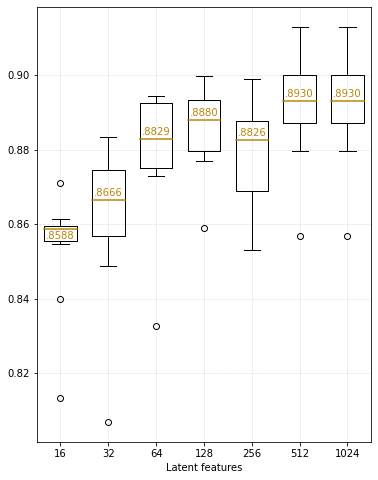

In [7]:
plot_scores(CONFIGS_BY_LATENT_FEATURES, scores, metric="auc", savefile="plots/approach4/boxplot_kde_latentfeatures.pdf", figsize=(6, 8), label_below=[0], xlabel="Latent features")

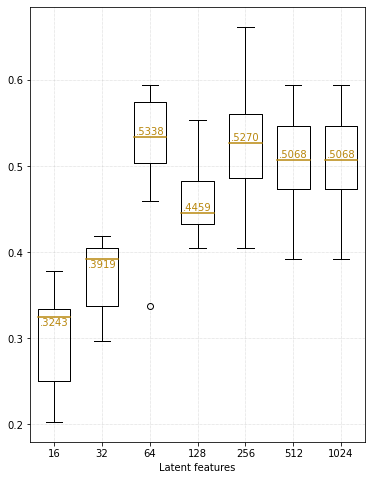

In [8]:
plot_scores(CONFIGS_BY_LATENT_FEATURES, scores, metric="tnr95", savefile="plots/approach4/boxplot_kde_latentfeatures_tnr95.pdf", figsize=(6, 8), label_below=[0, 1], xlabel="Latent features")

## Denoising autoencoders

In [9]:
denoising_and_sparse_scores = [get_scores(**config) for config in CONFIGS_DENOISING_AND_SPARSE]

Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


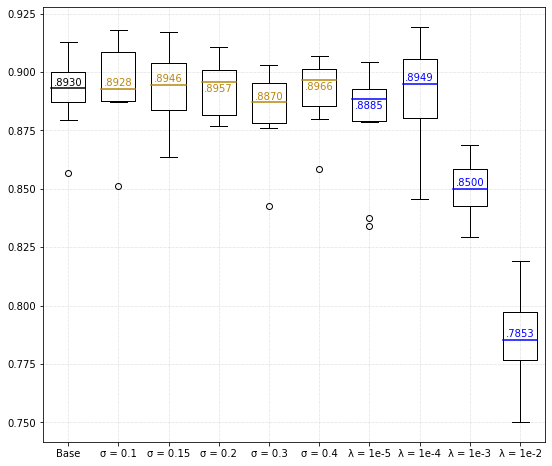

In [10]:
plot_scores(CONFIGS_DENOISING_AND_SPARSE, denoising_and_sparse_scores, metric="auc", savefile="plots/approach4/boxplot_kde_denoising_and_sparse.pdf", figsize=(9, 8), label_below=[3,5,6], colors = ["black"] + ["darkgoldenrod"] * 5 + ["blue"] * 4)

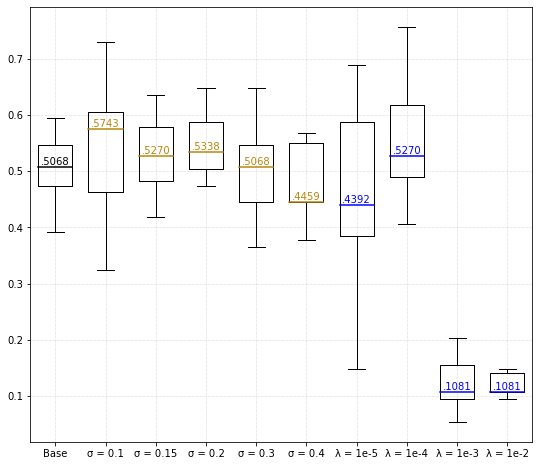

In [11]:
plot_scores(CONFIGS_DENOISING_AND_SPARSE, denoising_and_sparse_scores, metric="tnr95", savefile="plots/approach4/boxplot_kde_denoising_and_sparse_tnr95.pdf", figsize=(9, 8), label_below=[], colors = ["black"] + ["darkgoldenrod"] * 5 + ["blue"] * 4)

## Compare sessions

In [12]:
compare_sessions_scores = [get_scores(**config) for config in CONFIGS_COMPARE_SESSIONS]

Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Session 'Marten_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Marten_01
Loaded scans.


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Session 'GFox_03' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session03-VIELAAS_GFox_03
Loaded scans.


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


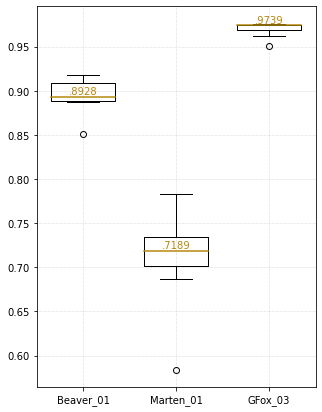

In [15]:
plot_scores(CONFIGS_COMPARE_SESSIONS, compare_sessions_scores, metric="auc", savefile="plots/approach4/boxplot_kde_sessions.pdf", figsize=(5, 7))

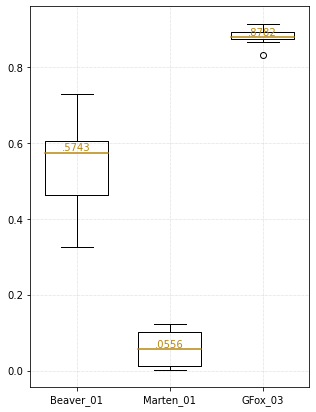

In [18]:
plot_scores(CONFIGS_COMPARE_SESSIONS, compare_sessions_scores, metric="tnr95", savefile="plots/approach4/boxplot_kde_sessions_tnr95.pdf", figsize=(5, 7))